## Visualization in Deep Learning

Visualization is a powerful tool for understanding and interpreting machine learning models. There are many different ways to visualize models, including visualizing the learned features, visualizing the activations, and visualizing the output of intermediate layers. <br/>

In this tutorial, we will cover the following topics: <br/>

0. [Load trained model from Hub](#load-trained-model-from-hub)
1. [Visualizing the learned features with Hub](#visualizing-the-learned-features-with-hub)
2. [Visualizing the class activation with Hub](#visualizing-the-class-activation-with-hub)

### Load trained model from Hub 
In this tutorial, we'll use our custom `Safety Dataset` that contains two classes: `Falldown` and `NotFalldown`. <br/>

In [1]:
import cv2
from matplotlib import pyplot as plt

def imshow(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')


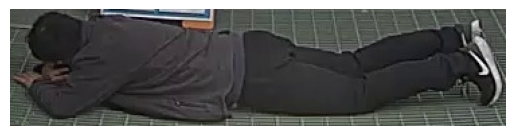

In [2]:
imshow("datasets/falldown/exports/YOLO/test/falldown/23_1080_4000kbps/622_frame_4080.jpg")

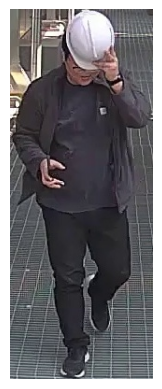

In [3]:
imshow("datasets/falldown/exports/YOLO/test/none/22_1080_4000kbps/256_frame_5250.jpg")

Load trained model

In [4]:
from waffle_hub.hub.adapter.ultralytics import UltralyticsHub

ultralytics_hub = UltralyticsHub.load("falldown_yolo")
ultralytics_model = ultralytics_hub.get_model()

/home/lhj/anaconda3/envs/waffle/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lhj/anaconda3/envs/waffle/lib/python3.9/site-packages/waffle_hub/__init__.py:56: UserWarning: 
                ultralytics 8.0.91 has not been tested.
                We recommend you to use one of ['8.0.87']
                
  warnings.warn(
/home/lhj/anaconda3/envs/waffle/lib/python3.9/site-packages/waffle_hub/__init__.py:56: UserWarning: 
                transformers 4.28.1 has not been tested.
                We recommend you to use one of ['4.27.4']
                
  warnings.warn(


### Visualizing the learned features with Hub

Hub provides several convinient functions to use trained models.

In [21]:
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt

def visualize_feature_maps(hub, image_path, target_layer):
    model = hub.get_model()
    load_image = hub.get_image_loader()
    
    image, image_info = load_image(image_path)
    _, feature_maps = model.get_feature_maps(image.clone().unsqueeze(0), target_layer)

    feature_map = list(feature_maps.values())[0]
    feature_map = feature_map.squeeze().mean(dim=0).detach().numpy()

    h, w = image.shape[1:]
    feature_map = cv2.resize(feature_map, (w, h))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].title.set_text("Input")
    axes[0].imshow(image.permute(1, 2, 0).detach().numpy())
    axes[0].axis('off')
    axes[1].title.set_text(f"{hub.backend}: {target_layer}")
    axes[1].imshow(feature_map)
    axes[1].axis('off')
    plt.show()

In [37]:
ultralytics_layers = list(filter(lambda x: ".bn" in x, ultralytics_model.get_layer_names()))
ultralytics_layers


['model.0.bn',
 'model.1.bn',
 'model.2.cv1.bn',
 'model.2.cv2.bn',
 'model.2.m.0.cv1.bn',
 'model.2.m.0.cv2.bn',
 'model.3.bn',
 'model.4.cv1.bn',
 'model.4.cv2.bn',
 'model.4.m.0.cv1.bn',
 'model.4.m.0.cv2.bn',
 'model.4.m.1.cv1.bn',
 'model.4.m.1.cv2.bn',
 'model.5.bn',
 'model.6.cv1.bn',
 'model.6.cv2.bn',
 'model.6.m.0.cv1.bn',
 'model.6.m.0.cv2.bn',
 'model.6.m.1.cv1.bn',
 'model.6.m.1.cv2.bn',
 'model.7.bn',
 'model.8.cv1.bn',
 'model.8.cv2.bn',
 'model.8.m.0.cv1.bn',
 'model.8.m.0.cv2.bn',
 'model.9.conv.bn']

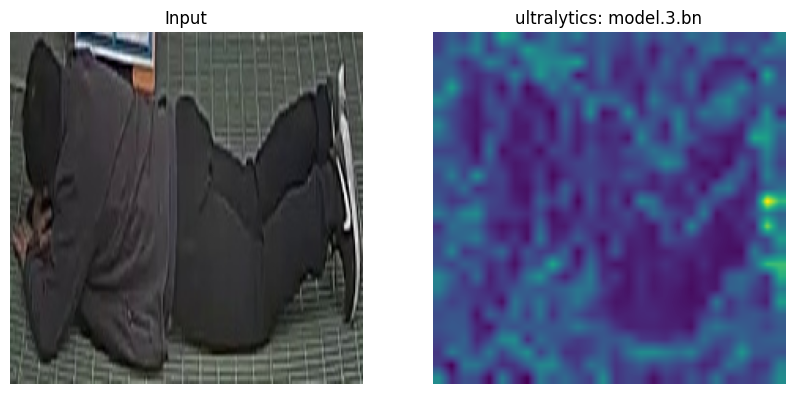

In [97]:
visualize_feature_maps(ultralytics_hub, "datasets/falldown/exports/YOLO/test/falldown/23_1080_4000kbps/622_frame_4080.jpg", "model.3.bn")

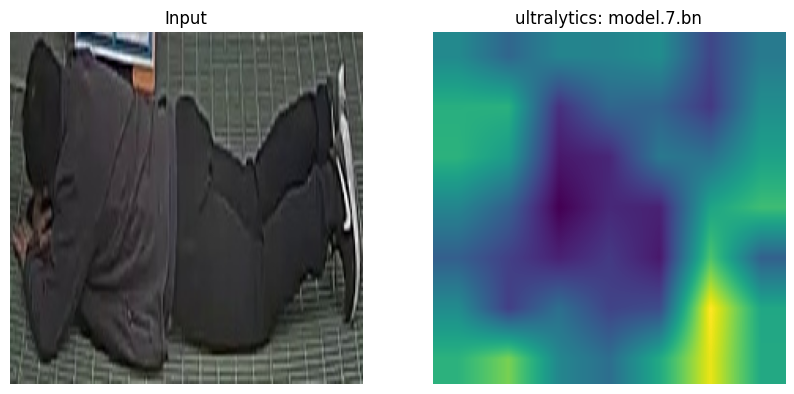

In [68]:
visualize_feature_maps(ultralytics_hub, "datasets/falldown/exports/YOLO/test/falldown/23_1080_4000kbps/622_frame_4080.jpg", "model.7.bn")

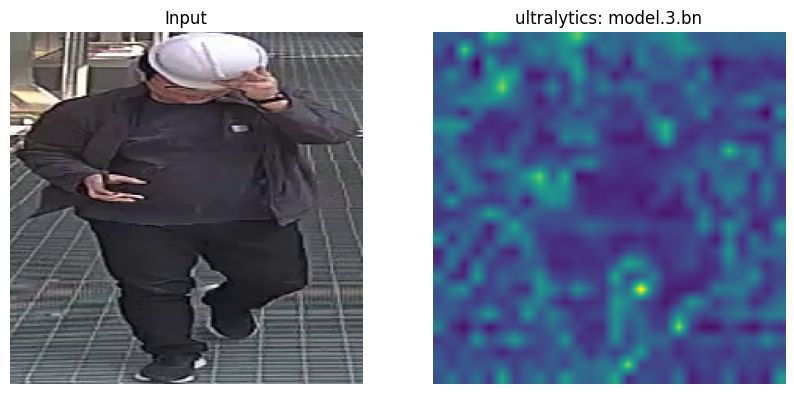

In [98]:
visualize_feature_maps(ultralytics_hub, "datasets/falldown/exports/YOLO/test/none/22_1080_4000kbps/256_frame_5250.jpg", "model.3.bn")

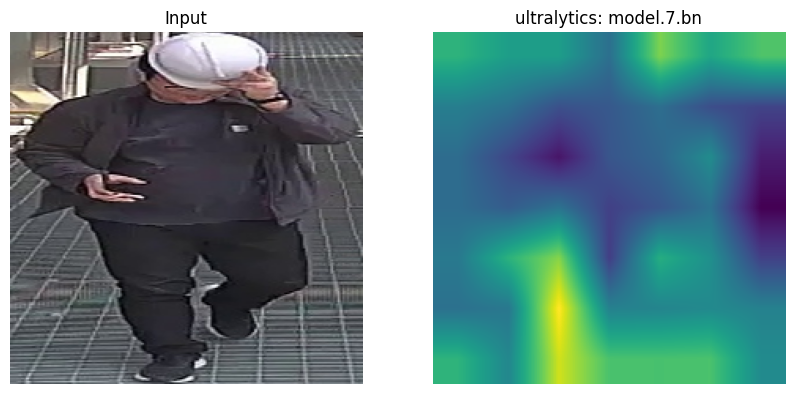

In [69]:
visualize_feature_maps(ultralytics_hub, "datasets/falldown/exports/YOLO/test/none/22_1080_4000kbps/256_frame_5250.jpg", "model.7.bn")

### Visualizing the class activation with Hub

Blend function for visualize GradCAM.

In [61]:
def blend(image, cam):
    """blend image and cam (same size and normalized)"""
    image = np.uint8(image.permute(1, 2, 0).detach().numpy() * 255)
    cam = np.uint8(cam.detach().numpy().squeeze() * 255)

    print(cam.shape)
    cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    return cv2.addWeighted(cam, 0.7, image, 0.3, 0)

def visualize_cam(hub, image_path, target_layer):
    model = hub.get_model()
    load_image = hub.get_image_loader()
    
    image, image_info = load_image(image_path)
    cam = model.get_cam(image.clone().unsqueeze(0), target_layer)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].title.set_text("Input")
    axes[0].imshow(image.permute(1, 2, 0).detach().numpy())
    axes[0].axis('off')
    axes[1].title.set_text(f"CAM {hub.backend}: {target_layer}")
    axes[1].imshow(blend(image, cam))
    axes[1].axis('off')
    plt.show()

### GradCAM with Ultralytics Hub

(224, 224)


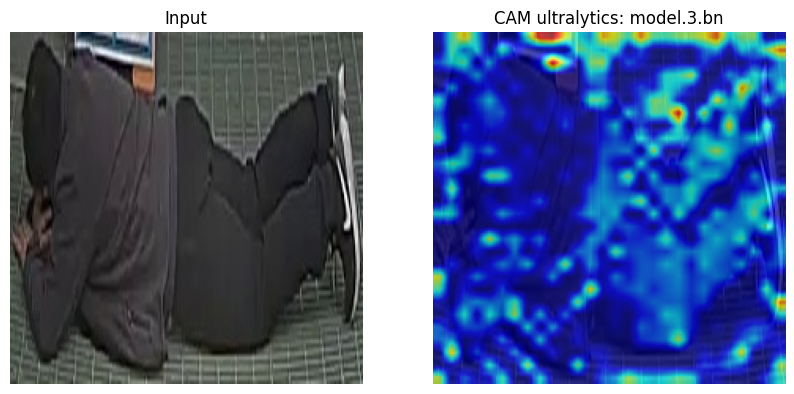

In [95]:
visualize_cam(ultralytics_hub, "datasets/falldown/exports/YOLO/test/falldown/23_1080_4000kbps/622_frame_4080.jpg", "model.3.bn")

(224, 224)


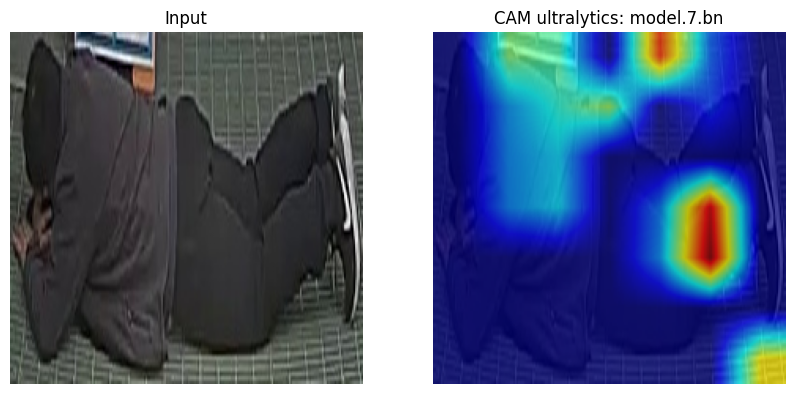

In [ ]:
visualize_cam(ultralytics_hub, "datasets/falldown/exports/YOLO/test/falldown/23_1080_4000kbps/622_frame_4080.jpg", "model.7.bn")

(224, 224)


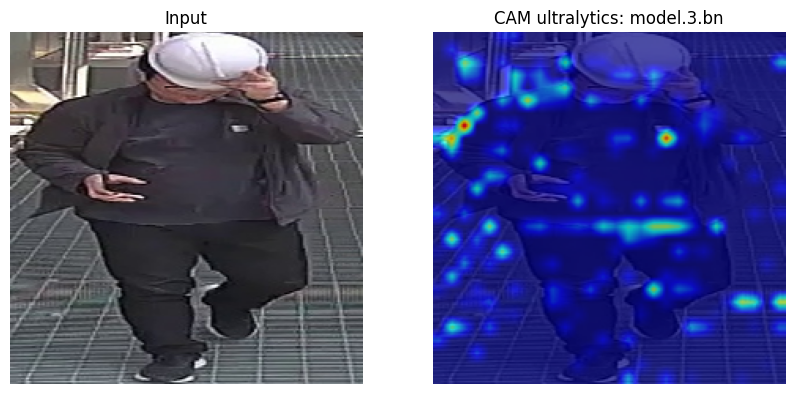

In [96]:
visualize_cam(ultralytics_hub, "datasets/falldown/exports/YOLO/test/none/22_1080_4000kbps/256_frame_5250.jpg", "model.3.bn")

(224, 224)


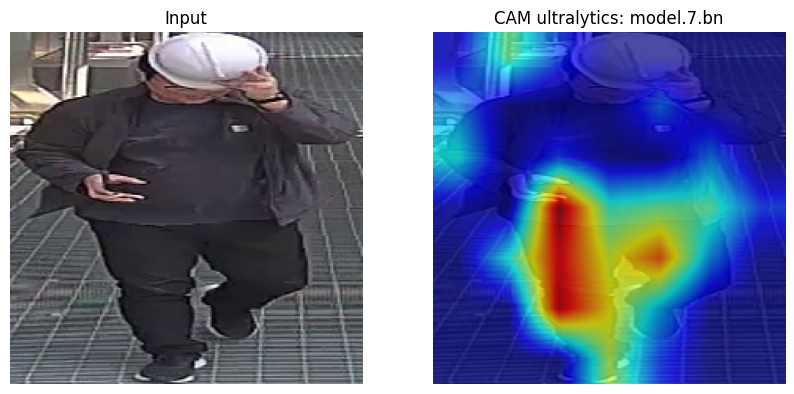

In [ ]:
visualize_cam(ultralytics_hub, "datasets/falldown/exports/YOLO/test/none/22_1080_4000kbps/256_frame_5250.jpg", "model.7.bn")

### GradCAM with Huggingface Hub
We also trained ViT-base model via Huggingface Hub.

In [73]:
from waffle_hub.hub.adapter.hugging_face import HuggingFaceHub

huggingface_hub = HuggingFaceHub.load("falldown_hf_ori")
huggingface_model = huggingface_hub.get_model()
huggingface_model.get_layer_names()

['',
 'vit',
 'vit.embeddings',
 'vit.embeddings.patch_embeddings',
 'vit.embeddings.patch_embeddings.projection',
 'vit.embeddings.dropout',
 'vit.encoder',
 'vit.encoder.layer',
 'vit.encoder.layer.0',
 'vit.encoder.layer.0.attention',
 'vit.encoder.layer.0.attention.attention',
 'vit.encoder.layer.0.attention.attention.query',
 'vit.encoder.layer.0.attention.attention.key',
 'vit.encoder.layer.0.attention.attention.value',
 'vit.encoder.layer.0.attention.attention.dropout',
 'vit.encoder.layer.0.attention.output',
 'vit.encoder.layer.0.attention.output.dense',
 'vit.encoder.layer.0.attention.output.dropout',
 'vit.encoder.layer.0.intermediate',
 'vit.encoder.layer.0.intermediate.dense',
 'vit.encoder.layer.0.intermediate.intermediate_act_fn',
 'vit.encoder.layer.0.output',
 'vit.encoder.layer.0.output.dense',
 'vit.encoder.layer.0.output.dropout',
 'vit.encoder.layer.0.layernorm_before',
 'vit.encoder.layer.0.layernorm_after',
 'vit.encoder.layer.1',
 'vit.encoder.layer.1.attention'

(224, 224)


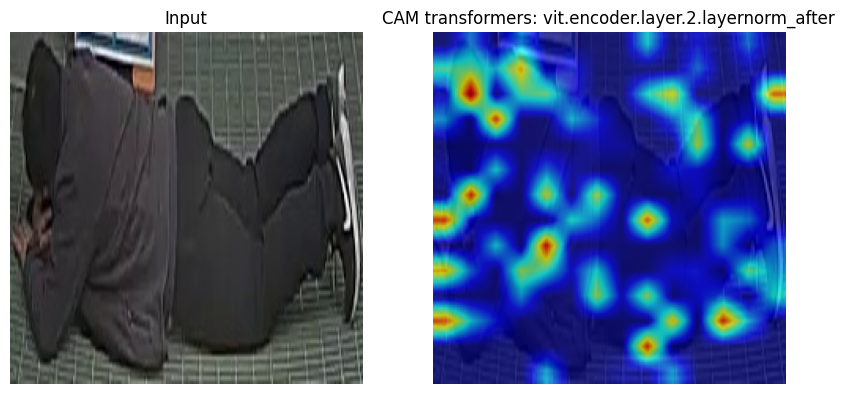

In [89]:
visualize_cam(huggingface_hub, "datasets/falldown/exports/YOLO/test/falldown/23_1080_4000kbps/622_frame_4080.jpg", "vit.encoder.layer.2.layernorm_after")

(224, 224)


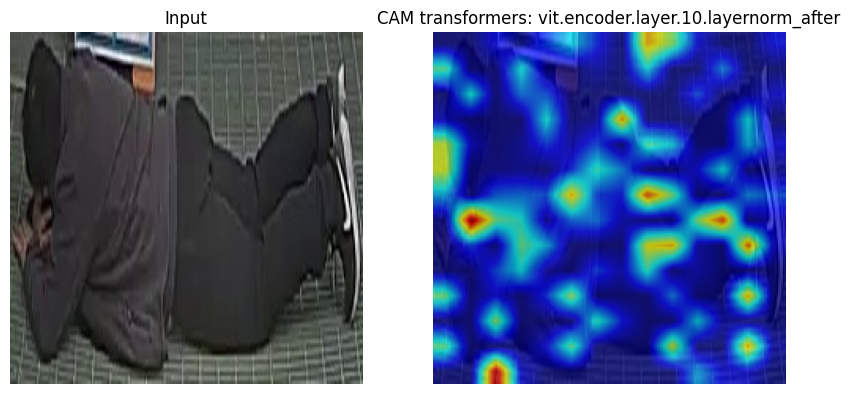

In [91]:
visualize_cam(huggingface_hub, "datasets/falldown/exports/YOLO/test/falldown/23_1080_4000kbps/622_frame_4080.jpg", "vit.encoder.layer.10.layernorm_after")

(224, 224)


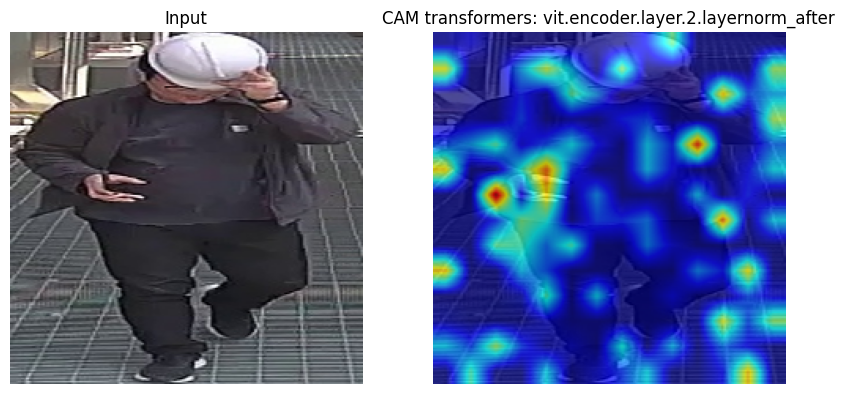

In [90]:
visualize_cam(huggingface_hub, "datasets/falldown/exports/YOLO/test/none/22_1080_4000kbps/256_frame_5250.jpg", "vit.encoder.layer.2.layernorm_after")

(224, 224)


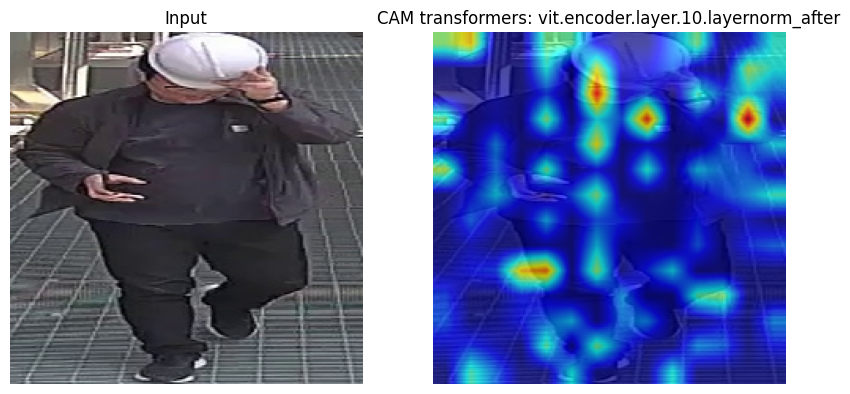

In [92]:
visualize_cam(huggingface_hub, "datasets/falldown/exports/YOLO/test/none/22_1080_4000kbps/256_frame_5250.jpg", "vit.encoder.layer.10.layernorm_after")